In [96]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

In [52]:
data = pd.read_csv('../Assets/train.txt', '\t', na_values={'is_news' : '?', 'alchemy_category_score' : '?',
                                                         'news_front_page' : '?'}).fillna(0)

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', '')).fillna('')
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', '')).fillna('')

In [53]:
data = pd.get_dummies(data, columns= ['alchemy_category'])

In [54]:
data.head()

url  \
0            http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html   
1         http://www.popsci.com/technology/article/2012-07/electronic-futuristic-starting-gun-eliminates-advantages-races   
2  http://www.menshealth.com/health/flu-fighting-fruits?cm_mmc=Facebook-_-MensHealth-_-Content-Health-_-FightFluWithFruit   
3                                            http://www.dumblittleman.com/2007/12/10-foolproof-tips-for-better-sleep.html   
4                     http://bleacherreport.com/articles/1205138-the-50-coolest-jerseys-you-didnt-know-existed?show_full=   

   urlid  \
0   4042   
1   8471   
2   1164   
3   6684   
4   9006   

                                                                                                                                                                                                                                                                                                   boilerplate  \
0  {"title":"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries","body":"A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at...   
1  {"title":"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races","body":"And that can be carried on a pla...   
2  {"title":"Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health","body":"Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent hea...   
3  {"title":"10 Foolproof Tips for Better Sleep ","body":"There was a period in my life when I had a lot of problems with sleep It took me very long to fall asleep I was easily awaken and I simply wasn t getting enough of rest at night I didn t want to take medication and this led me to learn sever...   
4  {"title":"The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen","body":"Jersey sales is a curious business Whether you re buying the stylish top to represent your favorite team player or color you re always missing out on better artwork With No 18 Colts jerseys continu...   

   alchemy_category_score  avglinksize  commonlinkratio_1  commonlinkratio_2  \
0                0.789131     2.055556           0.676471           0.205882   
1                0.574147     3.677966           0.508021           0.288770   
2                0.996526     2.382883           0.562016           0.321705   
3                0.801248     1.543103           0.400000           0.100000   
4                0.719157     2.676471           0.500000           0.222222   

   commonlinkratio_3  commonlinkratio_4  compression_ratio  embed_ratio  \
0           0.047059           0.023529           0.443783          0.0   
1           0.213904           0.144385           0.468649          0.0   
2           0.120155           0.042636           0.525448          0.0   
3           0.016667           0.000000           0.480725          0.0   
4           0.123457           0.043210           0.446143          0.0   

   framebased  frameTagRatio  hasDomainLink  html_ratio  image_ratio  is_news  \
0           0       0.090774              0    0.245831     0.003883      1.0   
1           0       0.098707              0    0.203490     0.088652      1.0   
2           0       0.072448              0    0.226402     0.120536      1.0   
3           0       0.095861              0    0.265656     0.035343      1.0   
4           0       0.024908              0    0.228887     0.050473      1.0   

   lengthyLinkDomain  linkwordscore  n

In [55]:
# Manually create dummy rows for words in title
data['recipe'] = data['title'].str.lower().str.contains('recipe')
data['electronic'] = data['title'].str.lower().str.contains('electronic')
data['tips'] = data['title'].str.lower().str.contains('tips')

In [56]:
# Function to extract coefficients from model
def examine_coefficients(model, df):
    df = pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : df.columns}
    ).sort_values(by='Coefficient')
    return df[df.Coefficient !=0 ]

In [57]:
# Create model for new dummy rows only
from sklearn.linear_model import LogisticRegression

X = data[[
        'recipe',
        'electronic',
        'tips'
    ]]
y = data.label


model = LogisticRegression() 

model.fit(X, y) # This fits the model to learn the coefficients

# See coefficients for each feature in model
examine_coefficients(model, X)

Coefficient     Feature
1    -0.441721  electronic
2     0.620250        tips
0     2.482849      recipe

In [58]:
# Create automation tool, specify parameters
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=50, # Only use the top 50 most common words
)


# Apply automation tool. 
# This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
X = v.fit_transform(data.title).todense()
X = pd.DataFrame(X, columns=v.get_feature_names())
print X.shape
X.head()


(7395, 50)


10  2011  allrecipes  apple  baked  best  blog  butter  cake  cheese  \
0   0     0           0      0      0     0     0       0     0       0   
1   0     0           0      0      0     0     0       0     0       0   
2   0     0           0      0      0     0     0       0     0       0   
3   1     0           0      0      0     0     0       0     0       0   
4   0     0           0      0      0     0     0       0     0       0   

   chicken  chocolate  com  cookies  cooking  cream  cupcakes  day  easy  \
0        0          0    0        0        0      0         0    0     0   
1        0          0    0        0        0      0         0    0     0   
2        0          0    0        0        0      0         0    0     0   
3        0          0    0        0        0      0         0    0     0   
4        0          0    0        0        0      0         0    0     0   

   fashion  food  foods  free  health  healthy  home  homemade  illustrated  \
0        0     0      0     0       0        0     0         0            0   
1        0     0      0     0       0        0     0         0            0   
2        0     0      0     0       1        0     0         0            0   
3        0     0      0     0       0        0     0         0            0   
4        0     0      0     0       0        0     0         0            0   

   insidershealth  kitchen  life  make  new  news  peanut  photos  pie  \
0               0        0     0     0    0     0       0       0    0   
1               0        0     0     0    0     0       0       0    0   
2               0        0     0     0    0     0       0       0    0   
3               0        0     0     0    0     0       0       0    0   
4               0        0     0     0    0     0       0       0    0   

   recipe  recipes  si  sports  style  sweet  swimsuit  technology  time  \
0       0        0   0       0      0      0         0           0     0   
1       0        0   0       0      0      0         0           0     0   
2       0        0   0       0      0      0         0           0     0   
3       0        0   0       0      0      0         0           0     0   
4       0        0   0       0      0      0         0           0     0   

   tips  video  ways  world  
0     0      0     0      0  
1     0      0     0      0  
2     0      0     0      0  
3     1      0     0      0  
4     0      0     0      0

In [59]:
data.columns

Index([u'url', u'urlid', u'boilerplate', u'alchemy_category_score',
       u'avglinksize', u'commonlinkratio_1', u'commonlinkratio_2',
       u'commonlinkratio_3', u'commonlinkratio_4', u'compression_ratio',
       u'embed_ratio', u'framebased', u'frameTagRatio', u'hasDomainLink',
       u'html_ratio', u'image_ratio', u'is_news', u'lengthyLinkDomain',
       u'linkwordscore', u'news_front_page', u'non_markup_alphanum_characters',
       u'numberOfLinks', u'numwords_in_url', u'parametrizedLinkRatio',
       u'spelling_errors_ratio', u'label', u'title', u'body',
       u'alchemy_category_?', u'alchemy_category_arts_entertainment',
       u'alchemy_category_business', u'alchemy_category_computer_internet',
       u'alchemy_category_culture_politics', u'alchemy_category_gaming',
       u'alchemy_category_health', u'alchemy_category_law_crime',
       u'alchemy_category_recreation', u'alchemy_category_religion',
       u'alchemy_category_science_technology', u'alchemy_category_sports',
    

In [61]:
# remove non-number columns
data.drop(['url', 'urlid', 'boilerplate', 'body', 'title'], axis=1, inplace=True)  
data.drop(['recipe', 'tips'], axis=1, inplace=True) # these are already in 'data', don't want to repeat column
dataz = data.join(X)

ValueError: labels ['recipe' 'tips' 'url' 'urlid' 'boilerplate' 'body' 'title'] not contained in axis

### Logistic Regression using L1 and L2 Regularization

In [84]:
# Instantiate Model
model = LogisticRegression()
model


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [75]:
# Choose Cs
Cs = [.01, .1, 1, 10, 100, 1000]

# Apply grid parameters
grid = GridSearchCV(estimator=model,
                    param_grid={'C' : Cs,
                               'fit_intercept' : [True, False],
                               'penalty' : ['l1', 'l2']
                               })                  

In [76]:
# Create x and y
x = dataz.drop('label',  axis=1)
y = dataz['label']

# fit to grid
grid.fit(x, y)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100, 1000], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [80]:
# View best score parameters
print(grid), '\n'
print grid.best_score_, '\n'
print grid.best_estimator_


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100, 1000], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0) 

0.738201487492 

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [85]:
# fit best model
best_model = grid.best_estimator_
best_model.fit(x, y)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
# see score of best model
best_model.score(x, y)

0.7436105476673428

In [88]:
examine_coefficients(best_model, x)

Coefficient                             Feature
56    -1.771130                             fashion
81    -1.737688                          technology
9     -1.249919                       frameTagRatio
70    -1.084350                                news
77    -0.883205                              sports
25    -0.784273  alchemy_category_computer_internet
84    -0.701275                               video
33    -0.673258             alchemy_category_sports
69    -0.543761                                 new
21    -0.502591               spelling_errors_ratio
16    -0.382267                     news_front_page
78    -0.379722                               style
11    -0.352550                          html_ratio
0     -0.352275              alchemy_category_score
43    -0.330997                                blog
38    -0.280901                                2011
37    -0.264565                                  10
65    -0.253844                      insidershealth
35    -0.237242            alchemy_category_weather
86    -0.233736                               world
72    -0.224855                              photos
82    -0.200555                                time
36    -0.198640                          electronic
54    -0.174535                                 day
59    -0.150925                                free
67    -0.144990                                life
10    -0.132812                       hasDomainLink
80    -0.112991                            swimsuit
27    -0.090173             alchemy_category_gaming
26    -0.071371   alchemy_category_culture_politics
..          ...                                 ...
3      0.370473                   commonlinkratio_2
71     0.524589                              peanut
2      0.600717                   commonlinkratio_1
40     0.611019                               apple
57     0.617316                                food
83     0.622790                                tips
28     0.623295             alchemy_category_health
4      0.629444                   commonlinkratio_3
55     0.631830                                easy
85     0.679499                                ways
50     0.721027                             cookies
24     0.723281           alchemy_category_business
79     0.726319                               sweet
39     0.771896                          allrecipes
63     0.889498                            homemade
51     1.016458                             cooking
73     1.094373                                 pie
52     1.243344                               cream
58     1.267431                               foods
68     1.293230                                make
75     1.344726                             recipes
48     1.365315                           chocolate
53     1.547989                            cupcakes
45     1.584592                                cake
46     1.602376                              cheese
44     1.617635                              butter
66     1.643148                             kitchen
41     1.917659                               baked
74     2.131112                              recipe
47     2.173098                             chicken

[86 rows x 2 columns]

In [93]:
# Create confusion Matrix
y_pred = best_model.predict(x)

conmat = np.array(confusion_matrix(y, y_pred))

confusion = pd.DataFrame(conmat, index=['seasonal', 'evergreen'],
                         columns=['predicted seasonal', 'predicted evergreen'])
confusion

predicted seasonal  predicted evergreen
seasonal                 2827                  772
evergreen                1124                 2672

In [99]:
2672/(2672+1124.0)

0.7038988408851422

In [95]:
# print classification report
cls_rep = classification_report(y, y_pred)
print(cls_rep)

             precision    recall  f1-score   support

          0       0.72      0.79      0.75      3599
          1       0.78      0.70      0.74      3796

avg / total       0.75      0.74      0.74      7395



(array([  0.00000000e+00,   0.00000000e+00,   2.77854960e-04, ...,
         9.99722145e-01,   9.99722145e-01,   1.00000000e+00]), array([  2.63435195e-04,   7.90305585e-03,   7.90305585e-03, ...,
         9.99736565e-01,   1.00000000e+00,   1.00000000e+00]), array([ 8.14335308,  6.06203649,  6.05452816, ..., -4.43802149,
       -4.5146243 , -4.53957076]))


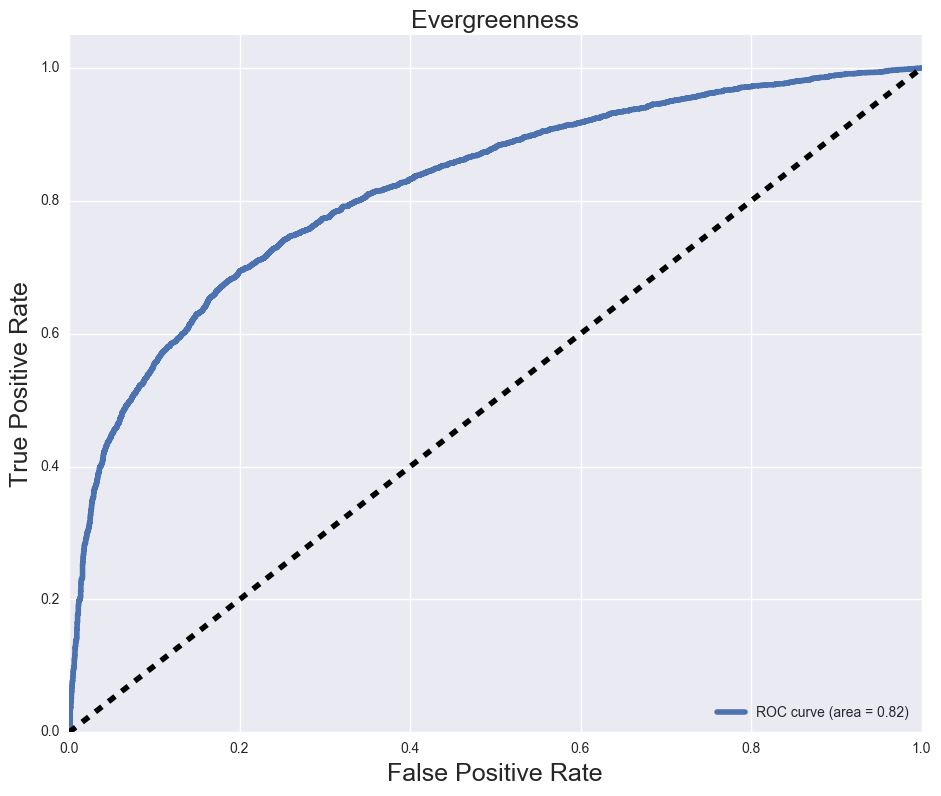

In [97]:
# create ROC and AUC
y_score = best_model.decision_function(x)

FPR = dict()
TPR = dict()
ROC_AUC = dict() # {}

# For class 1, find the area under the curve

print roc_curve(y, y_score)

FPR[1], TPR[1], _ = roc_curve(y, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])


# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Evergreenness', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [115]:
# Find the cutoff that was used in the model.  looks like it was .5
y_predictions = pd.DataFrame(y_pred, columns=['Prediction'])
y_pp = pd.DataFrame(best_model.predict_proba(x), 
                    columns=['prob_seasonal','prob_evergreen']).join(y_predictions)

y_pp[y_pp['Prediction'] == 1].sort_values('prob_evergreen')

prob_seasonal  prob_evergreen  Prediction
4082       0.499866        0.500134           1
5643       0.499789        0.500211           1
3968       0.499686        0.500314           1
1003       0.499420        0.500580           1
1376       0.499356        0.500644           1
5556       0.499302        0.500698           1
6592       0.499272        0.500728           1
3301       0.499091        0.500909           1
2390       0.498959        0.501041           1
4008       0.498919        0.501081           1
448        0.498814        0.501186           1
6870       0.498763        0.501237           1
4342       0.498755        0.501245           1
5963       0.498755        0.501245           1
2136       0.498737        0.501263           1
4148       0.498601        0.501399           1
6245       0.498556        0.501444           1
5426       0.498549        0.501451           1
4150       0.498426        0.501574           1
2006       0.498401        0.501599           1
6773       0.498391        0.501609           1
3497       0.498269        0.501731           1
5969       0.498265        0.501735           1
3307       0.498143        0.501857           1
486        0.498131        0.501869           1
560        0.498061        0.501939           1
3244       0.498024        0.501976           1
1398       0.497982        0.502018           1
6275       0.497854        0.502146           1
2318       0.497564        0.502436           1
...             ...             ...         ...
4491       0.002324        0.997676           1
1514       0.002247        0.997753           1
2121       0.002093        0.997907           1
464        0.002027        0.997973           1
2210       0.002015        0.997985           1
3573       0.002012        0.997988           1
2486       0.001956        0.998044           1
3073       0.001811        0.998189           1
3001       0.001717        0.998283           1
7119       0.001637        0.998363           1
5603       0.001634        0.998366           1
3070       0.001595        0.998405           1
2775       0.001523        0.998477           1
2573       0.001435        0.998565           1
1045       0.001340        0.998660           1
2219       0.001297        0.998703           1
2279       0.001273        0.998727           1
5047       0.001225        0.998775           1
5570       0.001157        0.998843           1
83         0.001037        0.998963           1
7320       0.001005        0.998995           1
4136       0.000961        0.999039           1
5446       0.000931        0.999069           1
2795       0.000714        0.999286           1
1737       0.000658        0.999342           1
3826       0.000654        0.999346           1
3448       0.000627        0.999373           1
6442       0.000599        0.999401           1
5178       0.000423        0.999577           1
3903       0.000291        0.999709           1

[3444 rows x 3 columns]